# Surface Barrier

## Functions

In [1]:
# %load ../../setup.py
"""
Packages for plotting and other stuff
version: 5.0
author: Riasat
"""
# uncomment the below line to use interactive plots
# %matplotlib widget

# data loading
import pandas as pd

# data maipulation
import pwlf
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.signal import find_peaks
from scipy import optimize

# plotting tools
import matplotlib.pyplot as plt

# extra tweaks
import warnings

warnings.filterwarnings("ignore")

# plot tweaks
plt.style.use("seaborn-poster")
pd.options.display.max_columns = None
pd.options.display.float_format = "{:.5f}".format

# function for extrapolation
def extrapolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(0, x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate2d(x, y):
    f = interp1d(x, y, kind="quadratic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate3d(x, y):
    f = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# funciton for polynomial fitting
def polfit(a, b, c):
    z = np.polyfit(a, b, c)
    f = np.poly1d(z)

    x = np.arange(a[0], a[len(a) - 1], 0.001)
    y = f(x)
    return x, y


# function for picewise linear fit
def picewise_linear_fit(x, y, segments):
    my_pwlf = pwlf.PiecewiseLinFit(x, y)  # fit my data
    res = my_pwlf.fit(segments)  # fit the data for n line segments
    # slopes = myPWLF.calc_slopes()  # calculate slopes

    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = my_pwlf.predict(xHat)

    # calculate statistics
    # p = myPWLF.p_values(method="non-linear", step_size=1e-4)  # p-values
    # se = myPWLF.se  # standard errors
    return xHat, yHat


# curve fit
def cur_fit(x, y):
    func = lambda t, a, c, d: a * np.log(t + c) + d
    popt, pcov = optimize.curve_fit(func, x, y)  # type: ignore
    xx = np.arange(x[0], x[len(x) - 1], 0.001)
    yy = func(xx, *popt)
    return xx, yy


def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
    # mean of x and y vector
    m_x = np.sum(x)
    m_y = np.sum(y)
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y * x)
    SS_xx = np.sum(x * x)
    deno = n * SS_xx - m_x * m_x
    # calculating regression coefficients
    b = (n * SS_xy - m_x * m_y) / deno
    a = (m_y * SS_xx - m_x * SS_xy) / deno

    return (a, b)


## Data

In [2]:
file_name = "data_surface.xlsx"
res_name = ["Am-241", "Pu-239", "Cm-244"]
# calibration data
data_cesium_calib = pd.read_excel(file_name, sheet_name="calibration")
peak_channel = data_cesium_calib["calib_channel"]
known_energy = data_cesium_calib["calib_energy"]

data_am = pd.read_excel(file_name, sheet_name='thick')
left_air = data_am['left_air']
right_air = data_am['right_air']
left_vacc = data_am['left_vacc']
right_vacc = data_am['right_vacc']
vaccum_peak = data_am['vaccum_peak']
air_peak	= data_am['air_peak']
thickness = data_am['thickness']
print(data_cesium_calib)

   calib_channel  calib_energy
0           1673       5.49000
1           1575       5.16000
2           1737       5.81000


## Calibration

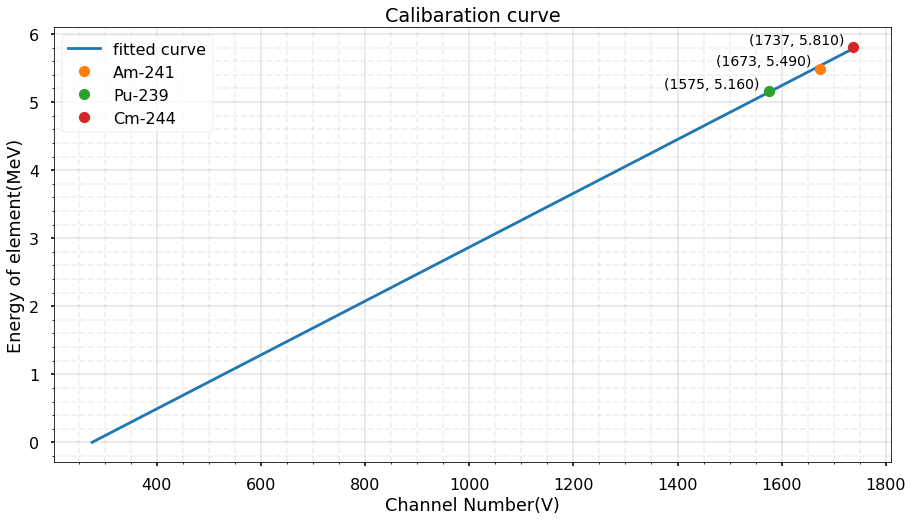

In [3]:
# extrapolated points
peak_channel_fit, known_energy_fit = polfit(peak_channel, known_energy, 1)
cal_chan_ext, cal_eng_ext = extrapolate1d(peak_channel_fit, known_energy_fit)

ckt = [item for item in cal_eng_ext if item >= 0]

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Calibaration curve")
plt.xlabel("Channel Number(V)")
plt.ylabel("Energy of element(MeV)")

plt.plot(cal_chan_ext[275635:], ckt, "-", label="fitted curve")
for i in range(len(res_name)):
    plt.plot(peak_channel[i], known_energy[i], "o", label=res_name[i])
    plt.annotate(f"({peak_channel[i]}, {known_energy[i]:.3f})", xy=(peak_channel[i]-200,known_energy[i]+0.05), fontsize=14)
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")
plt.show()


## FWHM

In [4]:
# air energy from calibration curve
peak_energy_air = np.interp(air_peak, cal_chan_ext, cal_eng_ext)
peak_energy_vaccum = np.interp(vaccum_peak, cal_chan_ext, cal_eng_ext)

data_am['energy air'] = peak_energy_air
data_am['energy vaccum'] = peak_energy_vaccum

# print(data_am)

## Thickness vs. energy

In [5]:
# observations
xe = thickness
ye_air = peak_energy_air
ye_vac = peak_energy_vaccum

# estimating coefficients
be_air = estimate_coef(xe, ye_air)
be_vac = estimate_coef(xe, ye_vac)
print(
    f"Estimated coefficients (Air): \n a = {be_air[0]:.3f} \n b = {be_air[1]:.3f} \
    \nEstimated coefficients (Vaccum): \n a = {be_vac[0]:.3f} \n b = {be_vac[1]:.3f}"
)

# predicted response vector
ye_pred_air = be_air[0] + be_air[1] * xe
ye_pred_vac = be_vac[0] + be_vac[1] * xe

Estimated coefficients (Air): 
 a = 4.970 
 b = -0.230     
Estimated coefficients (Vaccum): 
 a = 5.266 
 b = -0.218


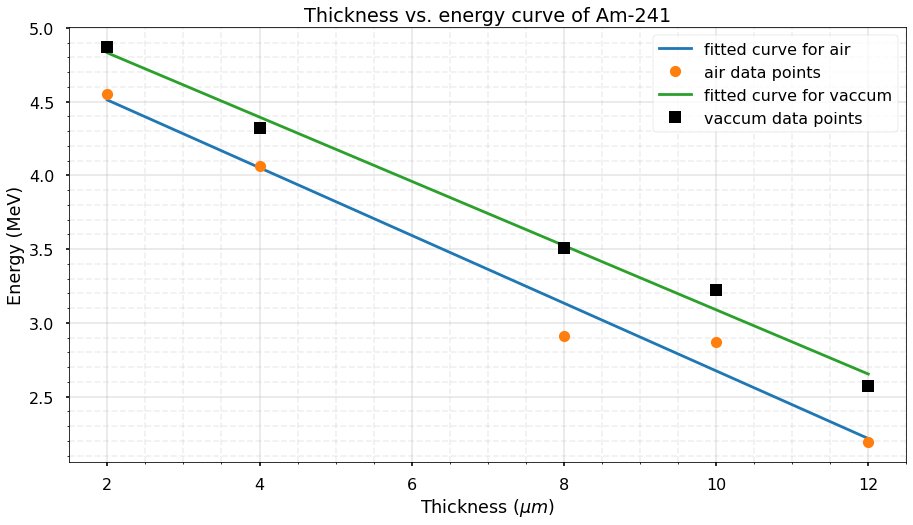

In [6]:
# thickness_fitted_air, peak_energy_air_fitted = polfit(thickness, peak_energy_air, 1)
# thickness_fitted_vaccum , peak_energy_vaccum_fitted = polfit(thickness, peak_energy_vaccum, 1)

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Thickness vs. energy curve of Am-241")
plt.xlabel(r"Thickness ($\mu m$)")
plt.ylabel("Energy (MeV)")

plt.plot(xe, ye_pred_air, "-", label="fitted curve for air")
plt.plot(thickness, peak_energy_air, "o", label='air data points')
plt.plot(xe, ye_pred_vac, "-", label="fitted curve for vaccum")
plt.plot(thickness, peak_energy_vaccum, "ks", label='vaccum data points')

plt.legend(loc="upper right")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")
plt.show()

## Thickness vs. FWHM

In [7]:
left_air_energy = np.interp(left_air, cal_chan_ext, cal_eng_ext)
right_air_energy = np.interp(right_air, cal_chan_ext, cal_eng_ext)
data_am['left_air_mev'] = left_air_energy
data_am['right_air_mev'] = right_air_energy
fwhm_air_mev = abs(left_air_energy - right_air_energy)

left_vaccum_energy = np.interp(left_vacc, cal_chan_ext, cal_eng_ext)
right_vaccum_energy = np.interp(right_vacc, cal_chan_ext, cal_eng_ext)
data_am['left_vac_mev'] = left_vaccum_energy
data_am['right_vac_mev'] = right_vaccum_energy
fwhm_vaccum_mev = abs(left_vaccum_energy - right_vaccum_energy)

data_am['fwhm_air_mev'] = fwhm_air_mev
data_am['fwhm_vaccum_mev'] = fwhm_vaccum_mev
print(data_am)

   thickness  vaccum_peak  air_peak  left_vacc  right_vacc  left_air  \
0          2         1506      1425       1345        1568      1326   
1          4         1367      1303       1206        1446      1138   
2          8         1162      1011        862        1255       798   
3         10         1090      1001        779        1177       724   
4         12          925       829        575        1024       537   

   right_air  energy air  energy vaccum  left_air_mev  right_air_mev  \
0       1491     4.54981        4.87045       4.15792        4.81108   
1       1372     4.06687        4.32022       3.41371        4.34001   
2       1094     2.91098        3.50872       2.06781        3.23953   
3       1093     2.87139        3.22370       1.77487        3.23558   
4        925     2.19052        2.57054       1.03463        2.57054   

   left_vac_mev  right_vac_mev  fwhm_air_mev  fwhm_vaccum_mev  
0       4.23313        5.11588       0.65316          0.88275  
1     

Estimated coefficients (Air): 
 a = 0.518 
 b = 0.088     
Estimated coefficients (Vaccum): 
 a = 0.662 
 b = 0.095


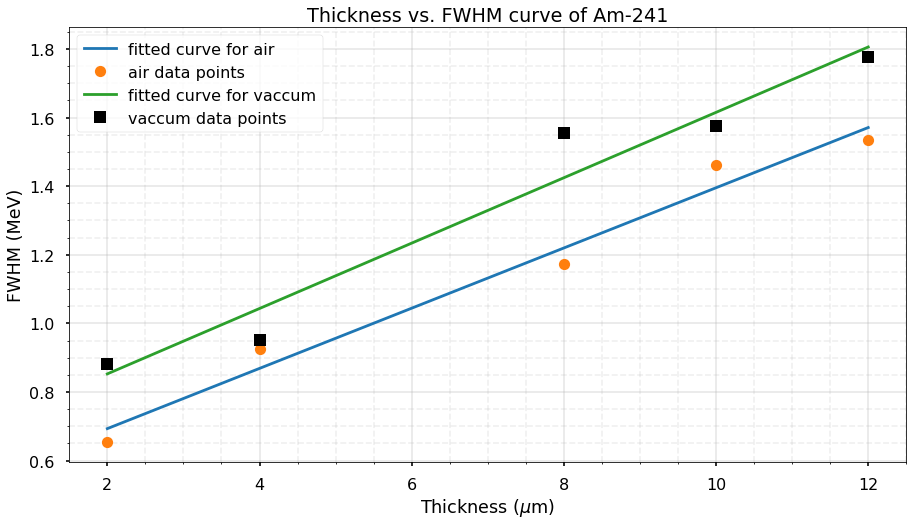

In [8]:
# observations
x = thickness
y_air = fwhm_air_mev
y_vac = fwhm_vaccum_mev

# estimating coefficients
b_air = estimate_coef(x, y_air)
b_vac = estimate_coef(x, y_vac)
print(
    f"Estimated coefficients (Air): \n a = {b_air[0]:.3f} \n b = {b_air[1]:.3f} \
    \nEstimated coefficients (Vaccum): \n a = {b_vac[0]:.3f} \n b = {b_vac[1]:.3f}"
)

# predicted response vector
y_pred_air = b_air[0] + b_air[1] * x
y_pred_vac = b_vac[0] + b_vac[1] * x

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Thickness vs. FWHM curve of Am-241")
plt.xlabel(r"Thickness ($\mu$m)")
plt.ylabel("FWHM (MeV)")

plt.plot(x, y_pred_air, "-", label="fitted curve for air")
plt.plot(thickness, fwhm_air_mev, "o", label="air data points")
plt.plot(x, y_pred_vac, "-", label="fitted curve for vaccum")
plt.plot(thickness, fwhm_vaccum_mev, "ks", label="vaccum data points")

plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")
plt.show()


### Linear regression table

#### energy vs. thickness

In [9]:
data_air = pd.DataFrame()
x = thickness
ya = peak_energy_air
xx = thickness * thickness
xya = thickness * ya

data_air["x"] = x
data_air["y"] = ya
data_air["xx"] = xx
data_air["xy"] = xya

print(
    f"Air regression: \n{data_air} \
	\n\n sx = {np.sum(x)}, \n sy = {np.sum(ya):.5f}, \n sxx= {np.sum(xx)} \n sxy = {np.sum(xya):.5f}"
)

data_vaccum = pd.DataFrame()

yv = peak_energy_vaccum
xyv = thickness*yv

data_vaccum["x"] = x
data_vaccum["y"] = yv
data_vaccum["xx"] = xx
data_vaccum["xy"] = xyv

print(
    f"\n\n Vaccum regression: \n{data_vaccum} \
	\n\n sx = {np.sum(x)}, \n sy = {np.sum(yv):.5f}, \n sxx= {np.sum(xx)} \n sxy = {np.sum(xyv):.5f}"
)

Air regression: 
    x       y   xx       xy
0   2 4.54981    4  9.09962
1   4 4.06687   16 16.26748
2   8 2.91098   64 23.28780
3  10 2.87139  100 28.71390
4  12 2.19052  144 26.28625 	

 sx = 36, 
 sy = 16.58957, 
 sxx= 328 
 sxy = 103.65505


 Vaccum regression: 
    x       y   xx       xy
0   2 4.87045    4  9.74091
1   4 4.32022   16 17.28087
2   8 3.50872   64 28.06972
3  10 3.22370  100 32.23700
4  12 2.57054  144 30.84649 	

 sx = 36, 
 sy = 18.49363, 
 sxx= 328 
 sxy = 118.17498


#### fwhm vs thickness

In [10]:
data_air = pd.DataFrame()
x = thickness
yaf = fwhm_air_mev
xx = thickness * thickness
xyaf = thickness * yaf

data_air["x"] = x
data_air["y"] = yaf
data_air["xx"] = xx
data_air["xy"] = xyaf

print(
    f"Air regression: \n{data_air} \
	\n\n sx = {np.sum(x)}, \n sy = {np.sum(yaf):.5f}, \n sxx= {np.sum(xx)} \n sxy = {np.sum(xyaf):.5f}"
)

data_vaccum = pd.DataFrame()

yvf = fwhm_vaccum_mev
xyvf = thickness*yvf

data_vaccum["x"] = x
data_vaccum["y"] = yvf
data_vaccum["xx"] = xx
data_vaccum["xy"] = xyvf

print(
    f"\n\n Vaccum regression: \n{data_vaccum} \
	\n\n sx = {np.sum(x)}, \n sy = {np.sum(yvf):.5f}, \n sxx= {np.sum(xx)} \n sxy = {np.sum(xyvf):.5f}"
)

Air regression: 
    x       y   xx       xy
0   2 0.65316    4  1.30632
1   4 0.92630   16  3.70520
2   8 1.17173   64  9.37383
3  10 1.46070  100 14.60702
4  12 1.53591  144 18.43097 	

 sx = 36, 
 sy = 5.74780, 
 sxx= 328 
 sxy = 47.42333


 Vaccum regression: 
    x       y   xx       xy
0   2 0.88275    4  1.76551
1   4 0.95005   16  3.80020
2   8 1.55571   64 12.44566
3  10 1.57550  100 15.75500
4  12 1.77739  144 21.32862 	

 sx = 36, 
 sy = 6.74140, 
 sxx= 328 
 sxy = 55.09499
